## Style transfer


In [1]:
# VGG-19 다운로드용 코드
import os
import urllib.request
import tarfile

model_dir = "model/"
tar_path  = "model/vgg_19_2016_08_28.tar.gz"
model_url = "http://download.tensorflow.org/models/vgg_19_2016_08_28.tar.gz"

if not os.path.exists(model_dir):
    os.makedirs(model_dir)    
    file_path, _ = urllib.request.urlretrieve(url=model_url, filename=tar_path)
    tarfile.open(name=tar_path, mode="r:gz").extractall(model_dir)

In [2]:
%matplotlib inline
import numpy as np
import scipy.misc as misc
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.slim as slim
from vgg import *

# content, style 레이어 정의
content_layer = "vgg_19/conv4/conv4_2"
style_layers  = ["vgg_19/conv1/conv1_1", "vgg_19/conv2/conv2_1",
                 "vgg_19/conv3/conv3_1", "vgg_19/conv4/conv4_1",
                 "vgg_19/conv5/conv5_1"]
style_weights = [0.5, 1.0, 1.5, 3.0, 4.0]

content_image_path = "images/content.jpg"
style_image_path   = "images/style.jpg"
height = 400
width  = 500

# 하이퍼 파라미터
lr = 2.0
alpha = 0.01
beta  = 1

In [3]:
inputs = tf.Variable(tf.zeros([1, height, width, 3]), dtype=tf.float32)

with slim.arg_scope(vgg_arg_scope()):
    _, model = vgg_19(inputs)
    
init_fn = slim.assign_from_checkpoint_fn("model/vgg_19.ckpt",
    slim.get_variables_to_restore(exclude=["vgg_19/fc6", "vgg_19/fc7", "vgg_19/fc8"]),
    ignore_missing_vars=True)

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess = tf.Session(config=sess_config)
sess.run(tf.global_variables_initializer())
init_fn(sess)

INFO:tensorflow:Restoring parameters from model/vgg_19.ckpt


In [4]:
mean_pixel = np.array([123.68, 116.779, 103.939]).reshape((1, 1, 1, 3))

# 이미지 로드
content_image = misc.imread(content_image_path)
style_image   = misc.imread(style_image_path)

content_image = misc.imresize(content_image, (height, width))
style_image   = misc.imresize(style_image, (height, width))

content_image = content_image.reshape(1, height, width, 3).astype(np.float32)
style_image   = style_image.reshape(1, height, width, 3).astype(np.float32)

# 이미지 정규화
content_image -= mean_pixel
style_image   -= mean_pixel

In [5]:
# content loss
sess.run(inputs.assign(content_image))
P = sess.run(model[content_layer])
F = model[content_layer]

content_loss = tf.reduce_sum((F - P) ** 2) / (4.0 * P.size)

In [6]:
# style loss
sess.run(inputs.assign(style_image))
A = sess.run([model[layer] for layer in style_layers])

def gram_matrix(F, N, M):
    F = tf.reshape(F, (M, N))
    return tf.matmul(tf.transpose(F), F)

def single_feature_style_loss(a, g):
    # N: 필터 수, M: 특징맵의 H*W
    N, M = a.shape[3], a.shape[1]*a.shape[2]
    gram_a = gram_matrix(a, N, M)
    gram_g = gram_matrix(g, N, M)
    return tf.reduce_sum((gram_g - gram_a) ** 2 / ((2*N*M)**2))

E = [single_feature_style_loss(A[i], model[layer]) for i, layer in enumerate(style_layers)]
style_loss = sum(style_weights[i] * E[i] for i in range(len(style_layers)))

In [7]:
total_loss = alpha*content_loss + beta*style_loss
opt = tf.train.AdamOptimizer(lr).minimize(total_loss)

In [8]:
def generate_noise_image(content_image, height, width, noise_ratio=0.6):
    noise_image = np.random.uniform(-20, 20, 
                                    (1, height, width, 3)).astype(np.float32)
    return noise_image * noise_ratio + content_image * (1 - noise_ratio)

initial_image = generate_noise_image(content_image, height, width, noise_ratio=0.6)

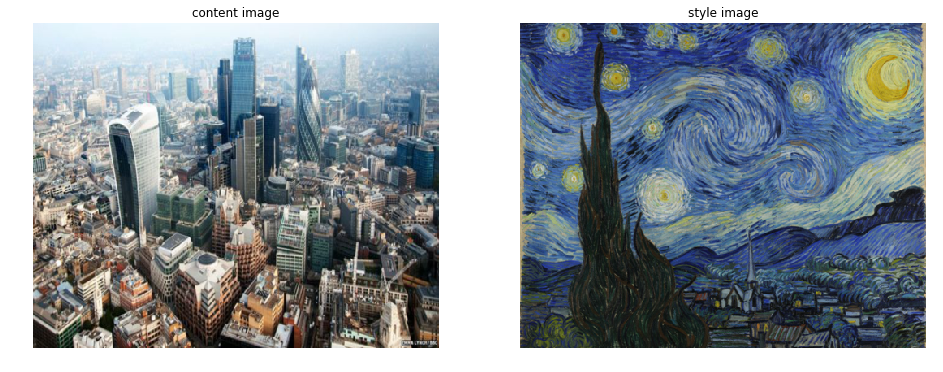

In [9]:
vis_content_image = (content_image+mean_pixel)[0].astype(np.uint8)
vis_style_image   = (style_image+mean_pixel)[0].astype(np.uint8)

fig = plt.figure(figsize=(16, 10))

a = fig.add_subplot(1, 2, 1)
a.set_title("content image")
a.axis("off")
plt.imshow(vis_content_image)

a = fig.add_subplot(1, 2, 2)
a.set_title("style image")
a.axis("off")
plt.imshow(vis_style_image)

INFO:tensorflow:Restoring parameters from model/vgg_19.ckpt
50 3.24132e+07
100 1.32634e+07
150 8.41895e+06
200 6.02614e+06
250 4.60984e+06
300 3.67858e+06


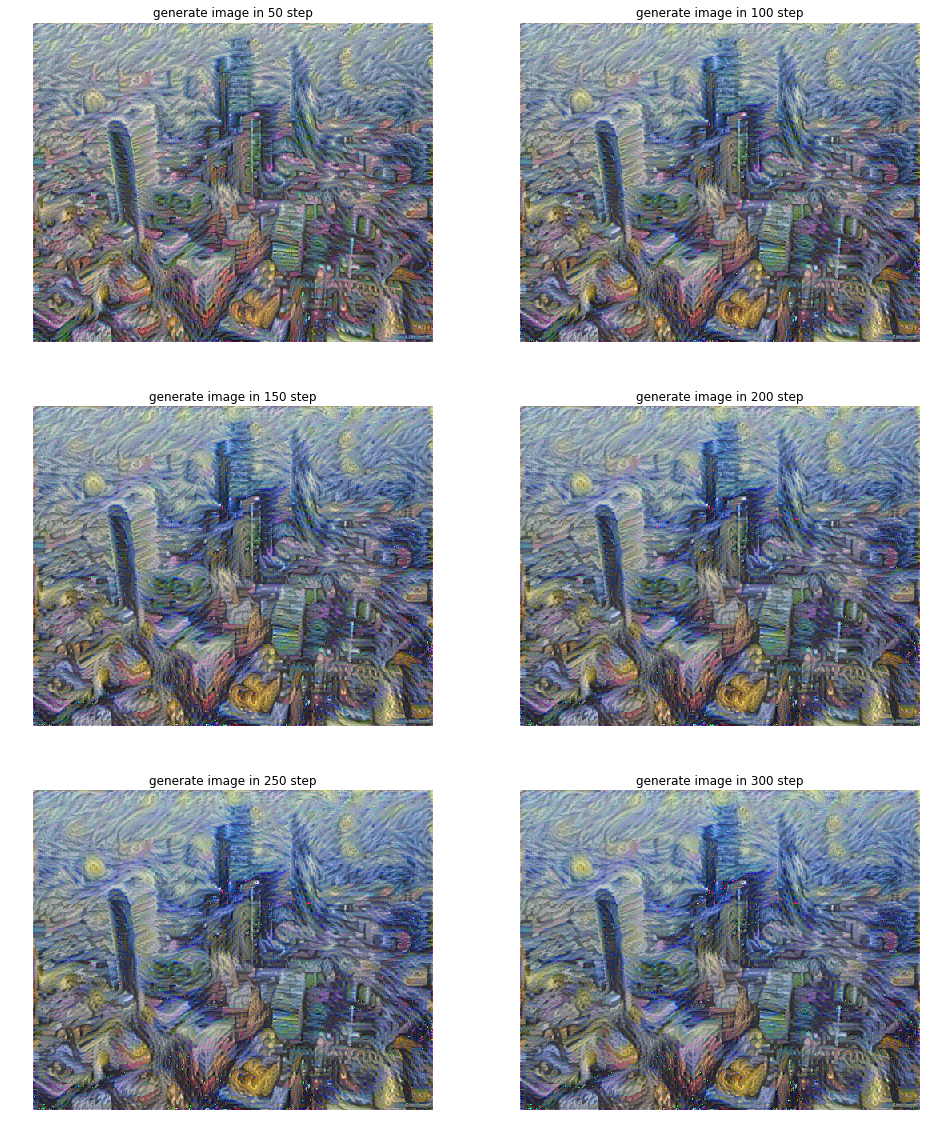

In [10]:
sess.run(tf.global_variables_initializer())
init_fn(sess)
sess.run(inputs.assign(initial_image))

i = 1
fig = plt.figure(figsize=(16, 20))

for step in range(300):
    sess.run(opt)
    if (step+1) % 50 == 0:
        gen_image, loss = sess.run([inputs, total_loss])
        print(step+1, loss)
        
        gen_image = (gen_image+mean_pixel).astype(np.uint8)
        gen_image = np.clip(gen_image, 0, 255)
        
        ax = fig.add_subplot(3, 2, i)
        ax.set_title("generate image in {} step".format(step+1))
        ax.axis("off")
        plt.imshow(gen_image[0])
        i += 1